In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
conti_stocks_df = pd.read_csv(r"D:\streamlit_learn\streamlit_learn\conti.csv")
conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04 00:00:00+02:00,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07 00:00:00+02:00,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08 00:00:00+02:00,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09 00:00:00+02:00,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10 00:00:00+02:00,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [3]:
# Convert with timezone awareness
conti_stocks_df['Date'] = pd.to_datetime(conti_stocks_df['Date'], utc=True)

# If you want to keep them timezone-naive but aligned to local time:
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_convert('Europe/Berlin')  # adjust to your tz
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_localize(None)

# Now you can floor to day
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.floor('D')

conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


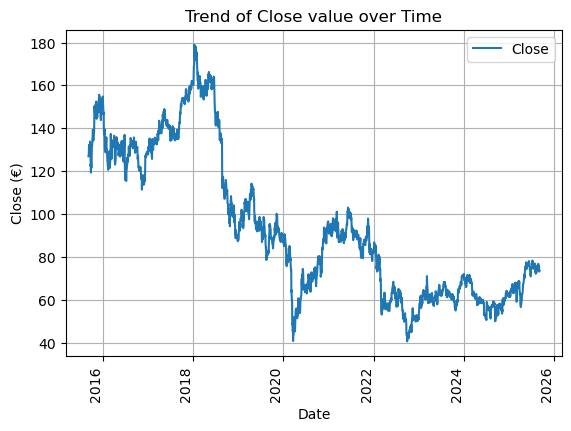

In [4]:
conti_stocks_df.plot(x='Date', y='Close', kind='line', title='Trend of Close value over Time')
plt.ylabel('Close (€)') # Add a y-axis label
plt.grid(True) # Add a grid for better readability
plt.tick_params(axis='x', rotation=90)
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(conti_stocks_df["Close"])
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -1.440, p-value = 0.563


In [6]:
values = conti_stocks_df['Close']

# getting the count to split the dataset into 10
parts = int(len(values) / 10)

# splitting the data into 10 parts using list comprehension
splits = [values[i*parts:(i+1)*parts] for i in range(10)]

# calculating the mean of the 10 parts
means = [part.mean() for part in splits]

# calculating the variance of the 10 parts
variances = [part.var() for part in splits]

# printing results
for i in range(10):
    print(f"Part {i+1}: mean={means[i]:.2f}, variance={variances[i]:.2f}")

Part 1: mean=133.90, variance=87.11
Part 2: mean=133.01, variance=67.27
Part 3: mean=154.84, variance=130.56
Part 4: mean=98.81, variance=69.42
Part 5: mean=74.76, variance=216.24
Part 6: mean=89.18, variance=60.90
Part 7: mean=71.00, variance=166.18
Part 8: mean=57.92, variance=49.46
Part 9: mean=61.73, variance=29.05
Part 10: mean=65.82, variance=60.11


In [7]:
conti_stocks_df_new = conti_stocks_df[['Date', 'Close']].copy()
df_diff = conti_stocks_df_new.set_index('Date')
df_diff = conti_stocks_df["Close"].diff().dropna()

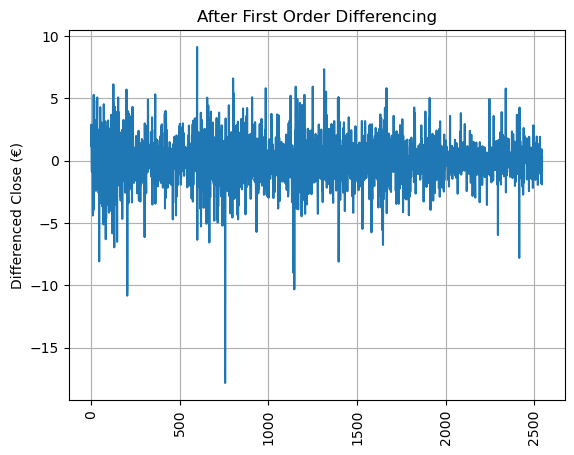

In [8]:
df_diff.plot(x='Date', y='Close', kind='line', title='After First Order Differencing')
plt.ylabel('Differenced Close (€)') # Add a y-axis label
plt.grid(True) # Add a grid for better readability
plt.tick_params(axis='x', rotation=90)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_diff)
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -50.318, p-value = 0.000


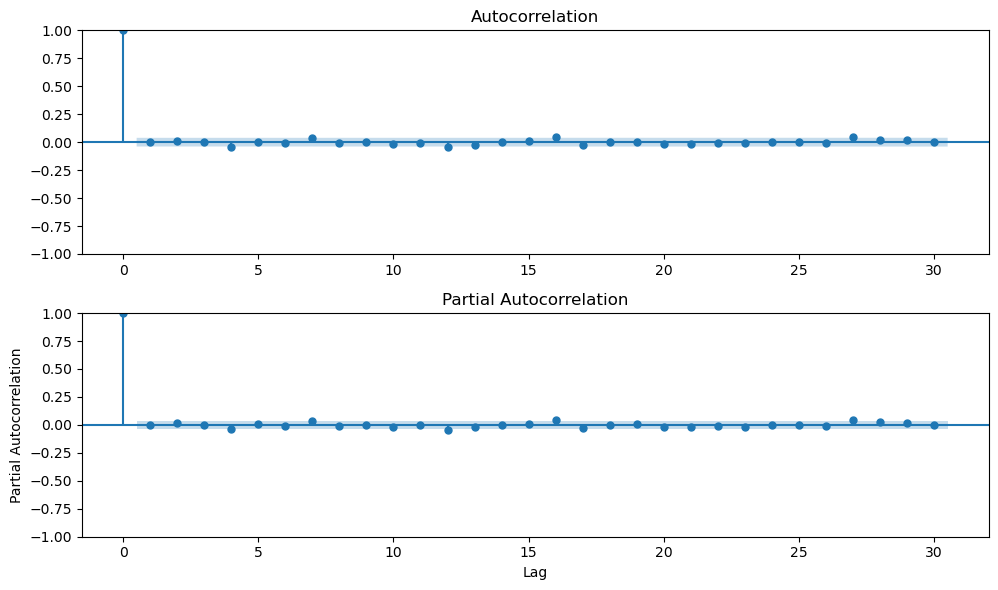

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_diff, lags=30, ax=ax[0])
plt.xlabel('Lag') # Add a x-axis label
plt.ylabel('Autocorrelation') # Add a y-axis label
plot_pacf(df_diff, lags=30, ax=ax[1])
plt.xlabel('Lag') # Add a x-axis label
plt.ylabel('Partial Autocorrelation') # Add a y-axis label
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# Function to fit ARIMA models with different p (lags) and return AIC scores
def select_best_lag(time_series, max_lag):
    aic_values = []
    
    for p in range(1, max_lag + 1):
        model = ARIMA(time_series, order=(p, 0, 0))  # ARIMA(p, d, q) where d=0 for AR model
        model_fit = model.fit()
        aic_values.append((p, model_fit.aic))
        
    return aic_values

# Set max_lag to try and get the best lag based on AIC
max_lag = 30
aic_scores = select_best_lag(conti_stocks_df_new['Close'], max_lag)

# Print the AIC values for different lags
for lag, aic in aic_scores:
    print(f'Lag: {lag}, AIC: {aic}')

# Find the lag with the minimum AIC value
best_lag = min(aic_scores, key=lambda x: x[1])[0]
print(f'\nOptimal Lag based on AIC: {best_lag}')

KeyboardInterrupt: 

In [12]:
n = len(df_diff)
train_end = int(n * 0.8)
train = df_diff.iloc[:train_end]
test = df_diff.iloc[train_end:]

In [13]:
from statsmodels.tsa.ar_model import AutoReg
p = 1
model = AutoReg(train, lags=p, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 2034
Model:                     AutoReg(1)   Log Likelihood               -4238.672
Method:               Conditional MLE   S.D. of innovations              1.946
Date:                Mon, 06 Oct 2025   AIC                           8483.345
Time:                        22:49:01   BIC                           8500.197
Sample:                             1   HQIC                          8489.527
                                 2034                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0320      0.043     -0.741      0.459      -0.117       0.053
Close.L1       0.0071      0.022      0.321      0.748      -0.036       0.051
                                    Roots           

c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
pred_train = model_fit.predict(start=train.index[p], end=train.index[-1], dynamic=False)
pred_test = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without 

In [15]:
last_train_value = conti_stocks_df["Close"].iloc[train_end]
forecast_orig = pred_test.cumsum() + last_train_value
forecast_orig.index = test.index

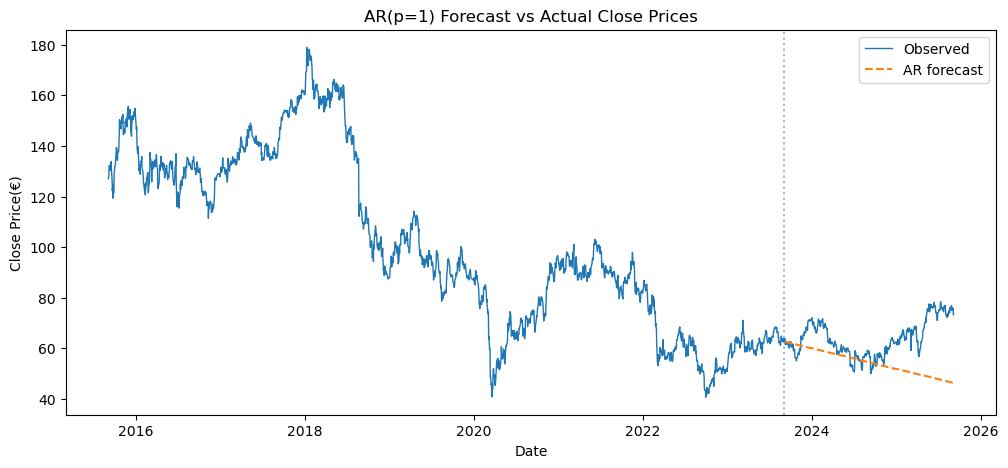

In [17]:
# Dates for the forecast period
forecast_dates = conti_stocks_df_new["Date"].iloc[train_end+1 : train_end+1+len(forecast_orig)]

plt.figure(figsize=(12,5))

# Plot full observed series
plt.plot(conti_stocks_df_new["Date"], conti_stocks_df_new["Close"], 
         label="Observed", linewidth=1)

# Plot forecast only for test period
plt.plot(forecast_dates, forecast_orig, 
         label="AR forecast", linestyle="--")

# Mark training end
plt.axvline(conti_stocks_df_new["Date"].iloc[train_end], 
            alpha=0.5, linestyle=":")
plt.xlabel('Date') # Add a x-axis label
plt.ylabel('Close Price(€)') # Add a y-axis label
plt.title("AR(p=1) Forecast vs Actual Close Prices")
plt.legend()
plt.show()



In [23]:
n = len(df_diff) + 1
train_end = int(n * 0.8)
train = conti_stocks_df_new.iloc[:train_end]
test = conti_stocks_df_new.iloc[train_end:]
test.head()

,Date,Close
2035,2023-09-05,63.891884
2036,2023-09-06,63.501171
2037,2023-09-07,62.049923
2038,2023-09-08,61.454540
2039,2023-09-11,62.496460


In [24]:
pred_test.head()

2035   -0.032210
2036   -0.032215
2037   -0.032215
2038   -0.032215
2039   -0.032215
dtype: float64

In [26]:
forecast_orig.head()

2035    62.668912
2036    62.636697
2037    62.604482
2038    62.572267
2039    62.540052
dtype: float64

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(test['Close'], forecast_orig))
mae = mean_absolute_error(test['Close'], forecast_orig)
mse = mean_squared_error(test['Close'], forecast_orig)
mape = np.mean(np.abs((test['Close'] - forecast_orig) / test['Close'])) * 100
r2 = r2_score(test['Close'], forecast_orig)
smape = 100 * np.mean(2 * np.abs(forecast_orig - test['Close']) / (np.abs(test['Close']) + np.abs(forecast_orig)))
print(f"\nPerformance Metrics for Testing:")
print(f"MAE  : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"sMAPE : {smape:.2f}%")
print(f"R^2 score : {r2:.2f}")


Performance Metrics for Testing:
MAE  : 10.1392
MSE : 188.1584
RMSE : 13.7171
MAPE : 14.73%
sMAPE : 16.84%
R^2 score : -2.81
